# Self-supervised and multi-modal representation Learning: Notebook 2

Here we will build a simple encoder for light curves, and try to train it to learn useful representation via masked autoencoding (i.e., predicting a missing part of the light curve).

## Light curve encoding via masked self-supervised learning

In [1]:
import sys, os

sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import torch
from torch.utils.data import DataLoader
import math

import torch
import torch.nn as nn
import pytorch_lightning as pl

from src.transformer_utils import TransformerWithTimeEmbeddings

from src.dataloader import SimulationLightcurveDataset

from src.models_pretraining import *

%load_ext autoreload
%autoreload 2

### Data loading and pre-processing

Let's start by loading the BTS data. The data contain variable number of light curves. For those with >100 observations pick 100 at random. Pad the shorter ones with zeros up to a length of 100. We'll also create a padding mask to be used in the encoder.

In [2]:
scotch = h5py.File("./sim_data/scotch_z3.hdf5", "r")

In [3]:
from collections import Counter

fullCount = 0
print("overview over dataset")
for key in list(scotch["TransientTable"].keys()):
    for key2 in list(scotch["TransientTable"][key].keys()):
        Nclass = len(scotch["TransientTable"][key][key2]["GID"][:])
        fullCount += Nclass
        print("%i %s events in the catalogue." % (Nclass, key2))
print("Total Number of Transients:")
print(fullCount)

overview over dataset
10000 AGN01 events in the catalogue.
90000 AGN20 events in the catalogue.
50000 KN_B19 events in the catalogue.
50000 KN_K17 events in the catalogue.
100000 SLSN-I events in the catalogue.
633000 SNII+HostXT_V19 events in the catalogue.
633000 SNII-NMF events in the catalogue.
633000 SNII-Templates events in the catalogue.
50000 SNIIn+HostXT_V19 events in the catalogue.
50000 SNIIn-MOSFIT events in the catalogue.
100000 SNIIb+HostXT_V19 events in the catalogue.
100000 SNIa-91bg events in the catalogue.
2000000 SNIa-SALT2 events in the catalogue.
100000 SNIax events in the catalogue.
50000 SNIb+HostXT_V19 events in the catalogue.
50000 SNIb-Templates events in the catalogue.
50000 SNIc+HostXT_V19 events in the catalogue.
50000 SNIc-Templates events in the catalogue.
100000 SNIcBL+HostXT_V19 events in the catalogue.
101000 TDE events in the catalogue.
Total Number of Transients:
5000000


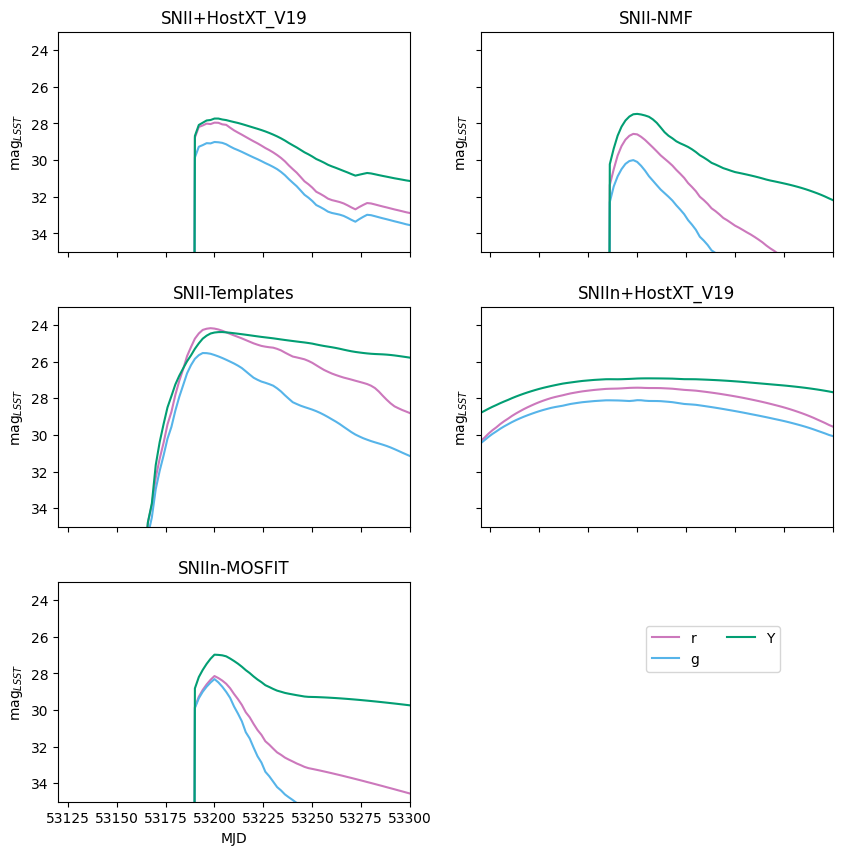

In [4]:
# Getting transients
scotch_transients = scotch["TransientTable"]
# SNII table
SNII = scotch_transients["SNII"]
SNII_models = list(SNII.keys())
# Choose bands
bands = "rgY"
# Plotting
cols = sns.color_palette("colorblind", 10)
cols_hex = cols.as_hex()
cols = np.array(
    [
        cols[3],
        cols[1],
        cols[8],
        cols[2],
        cols[9],
        cols[0],
        cols[4],
        cols[5],
        cols[7],
        cols[6],
    ]
)
cols = np.array(
    [
        sns.color_palette("colorblind", 10)[4],
        cols[4],
        cols[3],
        cols[0],
        "tab:red",
        cols[7],
    ],
    dtype="object",
)  # u and y probably need changing

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
axs[2, 1].set_axis_off()
plt.subplots_adjust(hspace=0.25, wspace=0.2)

for i in np.arange(len(SNII_models)):
    model = SNII_models[i]
    SNII_oneModel = SNII[model]
    ax = axs.ravel()[i]
    for j in np.arange(len(bands)):
        ax.plot(
            SNII_oneModel["MJD"][10],
            SNII_oneModel["mag_%s" % bands[j]][10],
            c=cols[j],
            label=bands[j],
        )
    if i == 0:
        ax.legend(bbox_to_anchor=(2.05, -1.7), borderaxespad=0, ncol=2)
    ax.set_ylim((35, 23))
    ax.set_xlim((53120, 53300))
    ax.set_ylabel("mag$_{LSST}$")
    ax.set_title(model)
axs.ravel()[4].set_xlabel("MJD");

In [5]:
# Usage
# dataset = SimulationLightcurveDataset('./data/sim_data/scotch_z3.hdf5', transient_types=['SNII', 'SNIa'], bands=['g', 'r'], n_max_obs=80)
dataset = SimulationLightcurveDataset(
    "./sim_data/scotch_z3.hdf5", transient_types=None, bands=["r","g"], n_max_obs=80
)
loader = DataLoader(dataset, batch_size=5, shuffle=True, num_workers=4)

In [6]:
next(iter(loader))[0].shape 

torch.Size([5, 160])

### Light curve encoder

We'll start with a simple transformer-based light curve encoder. Since transformers are inherenently permutation-equivariant (i.e., insensitive to ordering -- a permutation of the inputs leads to a corresponding permutation of the outputs), we'll need to add time encodings to "tell" the transformer the time corresponding to each observation. 

This is a simple way to be able to deal with variable-length, heterogeneously sampled light curves. There are many extensions to this basic idea, see e.g.
- https://arxiv.org/abs/2309.16316
- https://arxiv.org/abs/2308.06404
- https://www.aanda.org/articles/aa/full_html/2023/02/aa43928-22/aa43928-22.html

and feel free to implement ideas from these or others, e.g. learnable time encoding bases.

PyTorch has a boilerplate Transformer implementation (`nn.TransformerEncoder`), but we'll use a lower-level implementation in `models/transformer_utils.py` for a bit more flexibility if we need it. Feel free to play around with either in the block below, inspecting the outputs and their shape, effect of masking, effect of changing hyperparameters.

Now let's implement the light curve encoder. For more details on the time-encoding via fourier features, please see e.g., [here](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html#Positional-encoding), from where it was adapted. We'll include the time encoding dependence simply by adding the embeddings to the linear embeddings of individual light curve data points.

### Dataset prep and masking

Write a convenience function to get masks for the encoder.

### Train masked autoencoder

In [7]:
mlce = MaskedLightCurveEncoder(
    f_mask=0.15,
    lr=6e-4,
    nband = 2,
    transformer_kwargs={
        "n_out": 80,
        "emb": 256,
        "heads": 4,
        "depth": 12,
        "dropout": 0.002,
    },
)

In [8]:
from torch.utils.data import TensorDataset, DataLoader, random_split

val_fraction = 0.05
batch_size = 512
n_samples_val = int(val_fraction * len(dataset))

# dataset = TensorDataset(mag, time, mask)
# dataset = PaddedSinusoidDataset(n_max_obs=80, amp_range=(0.20, 0.50), num_samples=1000,freq_range = (0.05,0.05))
dataset_train, dataset_val = random_split(
    dataset, [len(dataset) - n_samples_val, n_samples_val]
)
train_loader = DataLoader(
    dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True
)
val_loader = DataLoader(
    dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False
)

In [9]:
trainer = pl.Trainer(max_epochs=5, accelerator="gpu")
trainer.fit(model=mlce, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                          | Params
-------------------------------------------------------
0 | net  | TransformerWithTimeEmbeddings | 9.5 M 
-------------------------------------------------------
9.5 M     Trainable params
0         Non-trainable params
9.5 M     Total params
38.040    Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/thelfer1/dev/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


### Evaluation: mask-filling

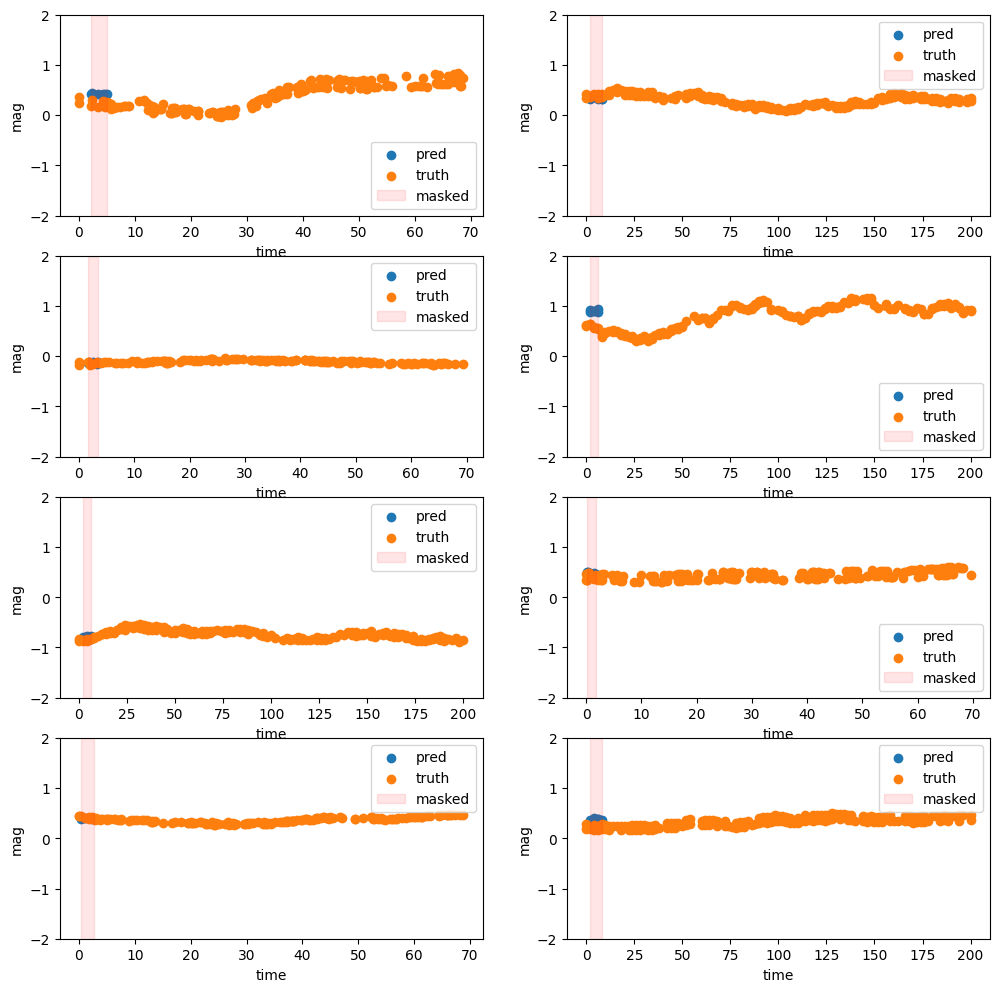

In [10]:
plot_masked_pretraining_model(mlce, val_loader, None)